# Intro
The idea here is to train a generator $G$ in the wavelet domain. We estimate $A \in \mathbb{R}^{n\times m}$ from ESPRESO and use it to create training data. The input to $G$ is $(c, d_i)$, coarse approximation and details computed from the DWT. The output of $G$ is $d_{i+1}$, the next detail level. Then we feed $(c, d_i, d_{i+1}$ into the IDWT to produce the next level 1D signal and immediately DWT at 1-level to produce $(c, d)$ at the next scale. This means the next generator still takes only 2 inputs.

Discriminators discriminate the detail at that level as well as the reconstructed signal at that level.

TODO: clean up math

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr/

/home/remedios/kaisr/kaisr


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

from pathlib import Path
import nibabel as nib

from utils.plot import *
from utils.train_loader_wavelet_1D import *
from tqdm import tqdm

set_display_mode('dark')
device = device = torch.device(f'cuda:0')

In [4]:
lr_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=np.float32)

gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)

lr_vol = np.pad(lr_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

In [5]:
slice_profile_fpath = Path("../results/filters/sub-OAS30003_ses-d0558_run-01_T1w/ESPRESO2_output/result.npy")

In [6]:
batch_size = 2**14
n_iters = 1000
n_levels = 1
a = -1
b = 1
scale = 4

lambdas = [1 for i in range(n_levels+1)]
sparsity_lambdas = [1 for i in range(n_levels)]
sparsity_lambdas.append(0) # no sparsity in coasre approximation
sparsity_lambdas.reverse()
# lambdas.reverse()

In [7]:
sparsity_lambdas

[0, 1]

In [8]:
lambdas

[1, 1]

In [9]:
ns = [int(64 / 2**(i+1)) for i in range(n_levels)]
ns.append(ns[-1])
ns.reverse()
ms = [n * scale for n in ns]

In [10]:
class Network(nn.Module):
    def __init__(self, ns, features, ms):
        super().__init__()
        
        self.projectors = nn.ModuleList([
            nn.Sequential(
                nn.Linear(n, features),
                nn.LeakyReLU(),
                nn.Linear(features, features),
                nn.LeakyReLU(),
                nn.Linear(features, m),
            ) for n, m in zip(ns, ms)
        ])
        
        self.convolvers =  nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(1, features, kernel_size=3, stride=1, padding='same'),
                nn.LeakyReLU(),
                nn.Conv1d(features, features, kernel_size=3, stride=1, padding='same'),
                nn.LeakyReLU(),
                nn.Conv1d(features, 1, kernel_size=3, stride=1, padding='same'),
            ) for m in ms
        ])


    def forward(self, xs):
        projections = [projector(x) for x, projector in zip(xs, self.projectors)]
        outputs = [convolver(x.unsqueeze(1)).squeeze() 
                   for x, convolver in zip(projections, self.convolvers)]
        return outputs

In [11]:
model = Network(ns=ns, features=512, ms=ms).to(device)

In [12]:
ds = TrainSet(
    vol_fpath=lr_fpath,
    slice_profile_fpath=slice_profile_fpath,
    gap=0,
    lr_dim=2,
    n_levels=n_levels,
    wavelet='haar',
)

loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)

In [13]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.L1Loss()

In [14]:
with tqdm(total=n_iters) as pbar:
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
    }
#     ys, xs = ds.__getitem__()
#     ys = [torch.from_numpy(y).to(device) for y in ys]
#     xs = [torch.from_numpy(x).to(device) for x in xs]

    for cur_epoch in range(n_iters):
        
        for ys_cpu, xs_cpu in loader:
            
            ys = [y.to(device) for y in ys_cpu]
            xs = [x.to(device) for x in xs_cpu]
        
            opt.zero_grad()
            xs_hat = model(ys)

            loss = 0
            for x_hat, x, loss_lambda, sparsity_lambda in zip(xs_hat, xs, lambdas, sparsity_lambdas):
                loss += loss_lambda * loss_fn(x_hat, x) + \
                 sparsity_lambda * torch.linalg.vector_norm(x_hat, ord=1)
                
            loss.backward()
            opt.step()

            pbar_dict['loss'] = loss.detach().cpu().numpy().item()
            pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:38<00:00,  4.57it/s, loss=0.2156]


# Evaluation on self

In [15]:
# normalize entire volume's intensity
lr_vol_norm, orig_min, orig_max = normalize(lr_vol, a=a, b=b)
lr_vol_norm = torch.from_numpy(lr_vol_norm)

In [16]:
# pull a slice
lr_img = lr_vol_norm[128]

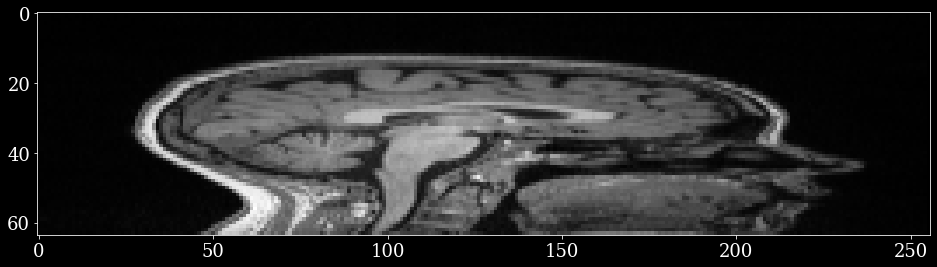

In [17]:
plt.imshow(np.rot90(lr_img))

In [18]:
lr_img.shape

torch.Size([256, 64])

In [19]:
# wavelet transform
lr_rows = list(pywt.wavedec(lr_img, wavelet='haar', level=n_levels))

In [20]:
# run through model
lr_rows = [torch.from_numpy(y).to(device) for y in lr_rows]
hr_rows = model(lr_rows)

In [21]:
# crop and compare to gt
gt_img = gt_vol[128]
gt_img, *_ = normalize(gt_img, a=a, b=b)

In [22]:
hr_rows = [t.detach().cpu().numpy() for t in hr_rows]

In [23]:
gt_rows = list(pywt.wavedec(gt_img, wavelet='haar', level=n_levels))

Unique GT: 2388
Unique Est: 31437


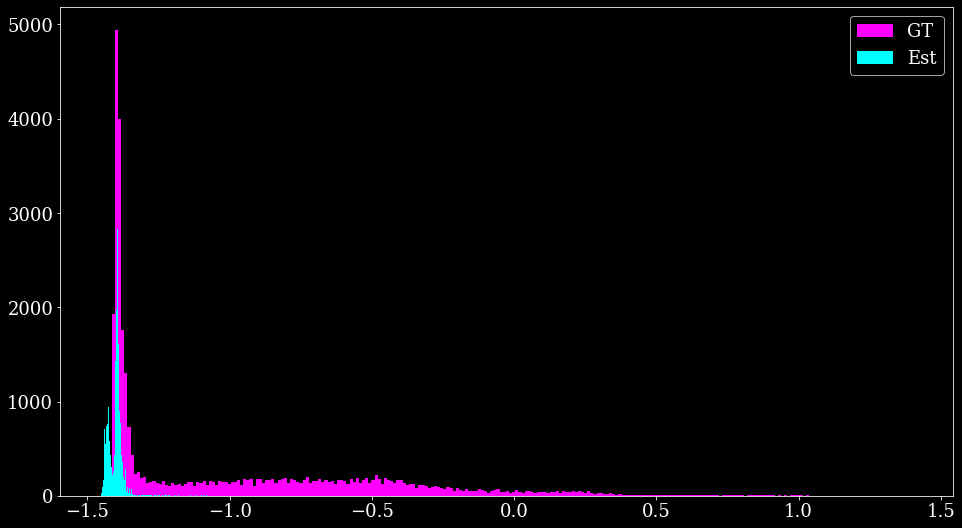

Unique GT: 2450
Unique Est: 29484


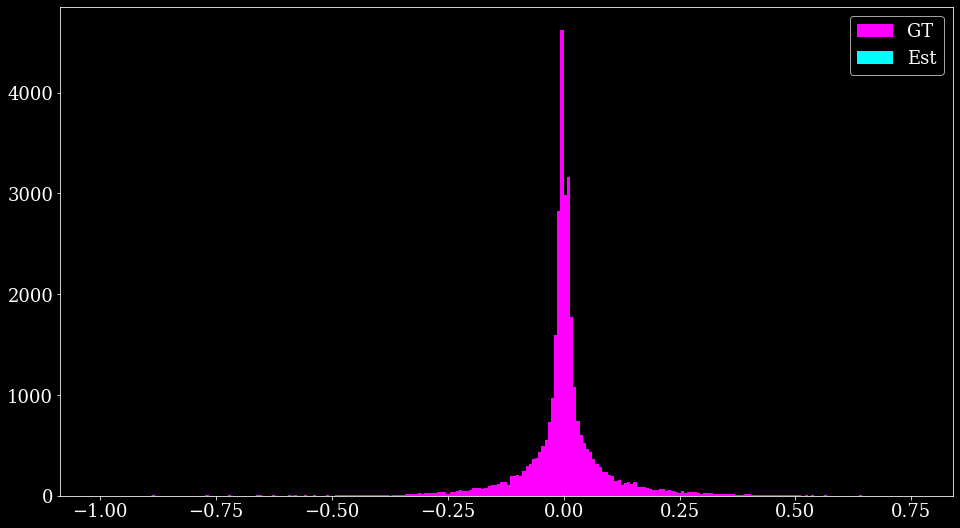

In [24]:
for i in range(len(gt_rows)):
    print("Unique GT:", len(np.unique(gt_rows[i])))
    print("Unique Est:", len(np.unique(hr_rows[i])))
    plt.hist(gt_rows[i].flatten(), bins=256, color='magenta', label='GT')
    plt.hist(hr_rows[i].flatten(), bins=256, color='cyan', label='Est')
    plt.legend()
    plt.show()

In [25]:
gt_rows[1][:5, :5]

array([[ 0.00696653, -0.0023222 , -0.02089971,  0.        ,  0.0023222 ],
       [-0.03251064,  0.00464439, -0.01161093, -0.01625532,  0.00696659],
       [ 0.01625532,  0.00232214, -0.0325107 , -0.03018844, -0.0023222 ],
       [ 0.00464433, -0.00928873,  0.01393306, -0.0023222 , -0.0023222 ],
       [ 0.        ,  0.01857752,  0.00696659, -0.01393312,  0.0023222 ]],
      dtype=float32)

In [26]:
hr_rows[1][:5, :5]

array([[-0.00042523,  0.00028284,  0.00071954,  0.00079802,  0.00086413],
       [-0.00043286,  0.00027956,  0.00072214,  0.00079771,  0.00086454],
       [-0.00043392,  0.0002793 ,  0.00072197,  0.00079702,  0.00086373],
       [-0.00043282,  0.0002794 ,  0.0007229 ,  0.00079784,  0.0008634 ],
       [-0.00041648,  0.00028598,  0.00072092,  0.00079737,  0.00086386]],
      dtype=float32)

In [27]:
# back to image space
hr_rows_img = pywt.waverec(hr_rows, wavelet='haar')

In [28]:
hr_img_hat = inv_normalize(hr_rows_img, orig_min, orig_max, a=a, b=b)

In [29]:
# gt back to image space
gt_rows_img = pywt.waverec(gt_rows, wavelet='haar')

In [30]:
hr_rows_img.min(), hr_rows_img.mean(), hr_rows_img.max()

(-1.027935, -0.9896505, -0.6772579)

In [31]:
gt_rows_img.min(), gt_rows_img.mean(), gt_rows_img.max()

(-1.0, -0.69994974, 0.99999994)

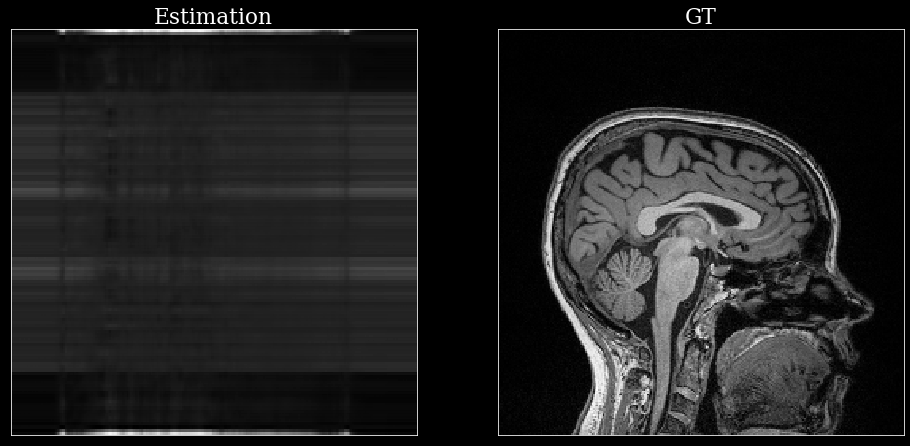

In [32]:
multiplot([hr_rows_img, gt_rows_img], titles=['Estimation', 'GT'])